# SVM Implementation
Author: Uwe Mueller, June, 2023 v1.0

Implementation of SVM with a weighted stochastic gradient descent algorithm.

#### Loss Function

$$
\frac{\lambda}{2} || w ||^2 + \frac{1}{n} \sum\limits_i max(0, 1 - y_i (w.x_i)) \qquad\qquad{(4.9)}
$$

#### Gradient 
$$

\
\begin{align*}
\nabla J(w) = \begin{cases}
-w + C \sum_{i=1}^{m} y^{(i)}x^{(i)}, & \text{if } y^{(i)}w^Tx^{(i)} < 1 \\
-w, & \text{otherwise}
\end{cases}
\end{align*}
\
$$

In [1]:
from __future__ import print_function
import re
import sys
import numpy as np
from operator import add
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from sklearn.datasets import make_blobs
from pandas import DataFrame
from matplotlib import pyplot
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt 

sc = SparkContext(master='local',appName="SVM")
spark = SparkSession(sparkContext=sc)
spark.sparkContext.setLogLevel('WARN')


In [2]:
# Implemeted weighted SVM function with stocastic gradient and regularization
def SVM_reg_weighted(data, learningRate, num_Iter, regularisation = 0, printcoeff = False):
	# Calculate the dimensionality of the inpit data
    num_samples = data.count()
    beta = 0.9
    d_input = len(data.first()[1])
    qti = coeff = nzeros = np.zeros(d_input)
    epsilon = 10e-12
    cost_list = []
        

	# The main iterative part of gradient descent algorithm 
    for i in range(num_Iter):
		# create mini batch
        mini_batch = data.sample(False, 800, i)
		# Seperately calculate the gradient for class 0 and class 1
        res0 = (mini_batch
                .filter(lambda x: x[0] == -1)
                .map(lambda x: (x[0], x[1], x[0]*np.dot(x[1], coeff)))
                .map(lambda x: (nzeros if x[2] > 1.0 else -1.0 * x[0] * x[1],\
                                max(0, 1 - x[2])))
                .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
        )
	
        res1 =  (mini_batch
                .filter(lambda x: x[0] == 1)
                .map(lambda x: (x[0], x[1], x[0]*np.dot(x[1], coeff)))
                .map(lambda x: (nzeros if x[2] > 1.0 else -1.0 * x[0] * x[1],\
                                max(0, 1 - x[2])))
                .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
        )

	# Calculate the combined weighted gradient for class 1 and 0
        gradients = w0 * res0[0] + w1 * res1[0]
        sum_cost = w0 * res0[1] + w1 * res1[1]	
	
	
	# Add L2 Regularization (sum of squared coefficients)
        cost=(sum_cost/float(num_samples))+regularisation*np.square(coeff).sum()
        gradient= (1.0/float(num_samples))*gradients+regularisation*2*coeff
        sq_grad = gradient ** 2
        exp_grad = beta * qti / (i + 1) + (1 - beta) * sq_grad
        coeff = coeff - learningRate / np.sqrt(exp_grad + epsilon) * gradient
        qti += sq_grad

        if printcoeff:
            print(f"{i} Cost:{cost:.5f} Coeff {coeff}")
		# Save the model parameters so we can eveluate the model on the test dataset.

		#append cost so we can plot it later
        cost_list.append(cost)

		# Check if cost is increasing at which point set conversion to False
        if i == 0:
            start_cost = cost

    return(cost_list, coeff, start_cost > cost )

In [3]:
# Calculate the Model performance based on the predicition coefficient and the test data and return accuracy, and f1 scores
def calc_modelperf(pred_coeff, test_data, printing = False):
    num_samples = test_data.count()
    predictions = test_data.map(lambda x: (x[0], 1 if np.dot(x[1],pred_coeff)>0 else -1))
    TP= predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
    FP = predictions.map(lambda x: 1 if (x[0]== -1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

    TN = predictions.map(lambda x: 1 if (x[0]== -1) and (x[1]==-1) else 0).reduce(lambda x,y:x+y)
    FN = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==-1) else 0).reduce(lambda x,y:x+y)

    # Calculate the Accuracy and the F1
    accuracy = (TP+TN)/(num_samples)
    f1 = (2*TP)/((2*TP) + FP + FN)
    if TP + FP ==0:
          precision = 0
    else:
          precision = TP / (TP + FP)
    if TP + FN == 0:
          recall = 0
    else:
          recall = TP / (TP + FN)

    # Print the Contingency matrix
    if printing: 
        print("--Contingency matrix--")
        print(f" TP:{TP:6}  FP:{FP:6}")
        print(f" FN:{FN:6}  TN:{TN:6}")
        print("----------------------")
        print(f"Accuracy = {accuracy:.4g}  \nF1 = {f1:.4g} \nPrecision = {precision:.4g}\nRecall = {recall:.4g}")
    
    return (accuracy, f1)


### Create Training/Test Data Set

In [4]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 4 # max iterations 
n=100000 # the number of total samples

ratio_positive = 0.5 # The classes ratio.
n_samples = [int(n*(1-ratio_positive)), int(n*ratio_positive)]
n_components = [1,1]
n_samples

# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n_samples, # the number of total samples
                  centers=None, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = 1.2, # the std of each cluster
                  random_state=2) # 2

In [5]:
# We need to fix the labels so that the labels are -1 and 1 as SVM expects them
y = [-1 if x == 0 else 1 for x in y]

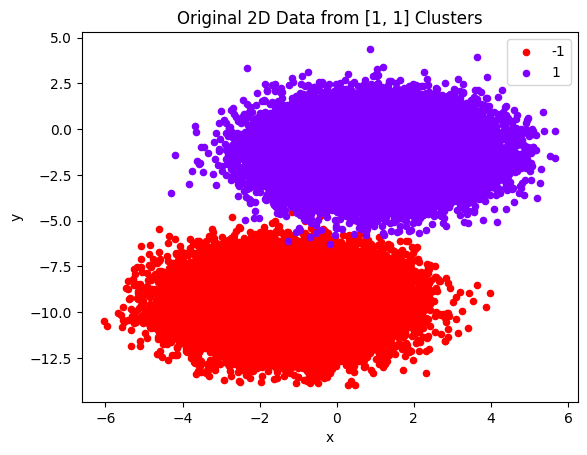

In [6]:
# Code for plotting the data
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

In [7]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
# Add: map(lambda x: (x[0],np.append(x[1],1)))
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.8, 0.2], seed=12345)
traindata = traindata.map(lambda x: (x[0],np.append(x[1],1)))
testdata  = testdata.map(lambda x: (x[0],np.append(x[1],1)))
traindata.cache()
train_size = traindata.count()
t = (traindata
    .map(lambda x: (0 if x[0] == -1 else 1,0 if x[0] == 1 else 1, 1))
    .reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
	)

# Check balance of the data and set the weights correctly
print("(n of 1, 0 and total):", t)
w0 = t[2] / (2*t[1])
w1 = t[2] / (2*t[0])
print("Weights class 0 and 1:", w0,w1)


(n of 1, 0 and total): (39988, 40037, 80025)
Weights class 0 and 1: 0.9993880660389141 1.0006126838051415


In [8]:
# Train the SVM
rescost, rescoeff, _ = SVM_reg_weighted(traindata, learningRate = 0.009, num_Iter = 10, regularisation=0.002, printcoeff = True) 

0 Cost:1.00000 Coeff [0.0284605 0.0284605 0.       ]
1 Cost:0.85112 Coeff [0.04059511 0.04059582 0.        ]
2 Cost:0.78764 Coeff [0.05135131 0.05135264 0.        ]
3 Cost:0.73138 Coeff [0.06157374 0.06157571 0.        ]
4 Cost:0.67791 Coeff [0.07148758 0.07145712 0.02844799]
5 Cost:0.62655 Coeff [0.08057342 0.07937689 0.05687738]
6 Cost:0.58558 Coeff [0.08735883 0.08034954 0.08424734]
7 Cost:0.57399 Coeff [0.09412806 0.08134017 0.10344761]
8 Cost:0.56267 Coeff [0.10049925 0.08121968 0.12078902]
9 Cost:0.55592 Coeff [0.10694283 0.08136578 0.13589993]


In [20]:
# Display Confusion Matrix and some comoon performance metrics
calc_modelperf(rescoeff, testdata, printing=True)

--Contingency matrix--
 TP:  9626  FP:   221
 FN:   386  TN:  9742
----------------------
Accuracy = 0.9696  
F1 = 0.9694 
Precision = 0.9776
Recall = 0.9614


(0.9696120150187735, 0.9694345133188982)

In [11]:
spark.stop()